# Q1
### Weighted MCMC

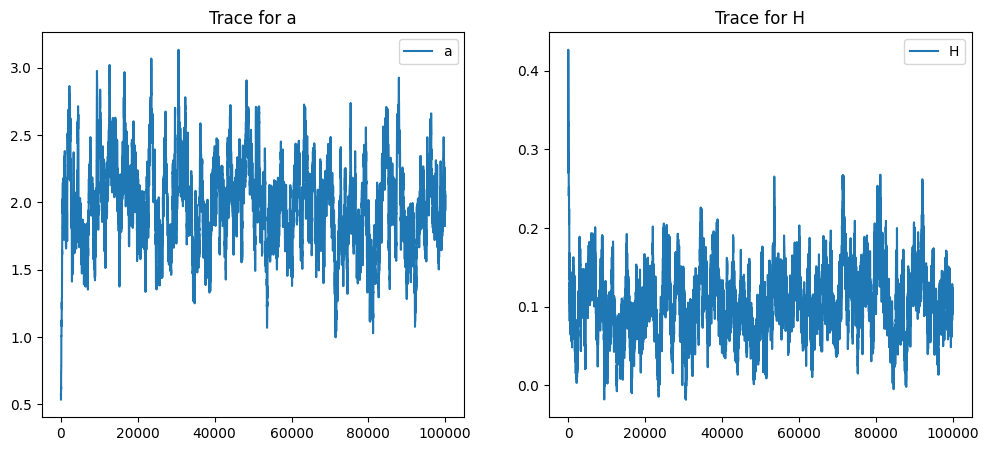

Estimated a: 1.983 ± 0.318
Estimated H: 0.105 ± 0.043


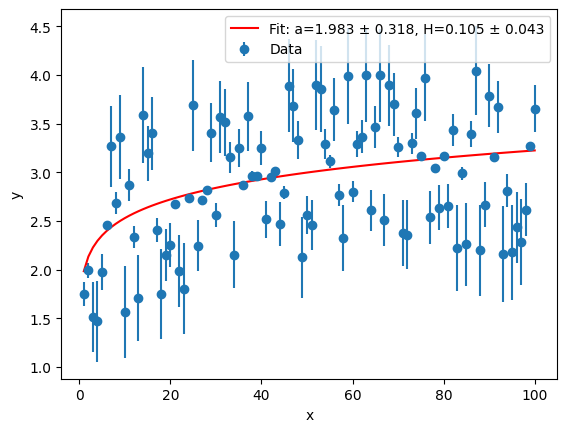

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt("dataexp2.txt")
x = data[:, 0]  # First column as x
y = data[:, 1]  # Second column as observed y
errors = data[:, 2]  # Third column as errors

# Define the model
def y_theory(x, a, H):
    return a * x**H

# MCMC Implementation
def mcmc(x, y, errors, n_iter=100000, init_params=(1.0, 1.0), step_sizes=(0.1, 0.1)):
    a_current, H_current = init_params
    step_a, step_H = step_sizes

    # Store samples
    samples = []

    # Initial likelihood
    def log_likelihood(a, H, sigmas = 1):
        model = y_theory(x, a, H)
        return -0.5 * np.sum(((y - model) / sigmas)**2)

    current_likelihood = log_likelihood(a_current, H_current, sigmas = errors)

    for _ in range(n_iter):
        # Propose new values
        a_proposed = a_current + np.random.uniform(-step_a, step_a)
        H_proposed = H_current + np.random.uniform(-step_H, step_H)

        # Compute proposed likelihood
        proposed_likelihood = log_likelihood(a_proposed, H_proposed)

        # Acceptance criterion
        if proposed_likelihood - current_likelihood > np.log(np.random.uniform(0, 1)):
            a_current, H_current = a_proposed, H_proposed
            current_likelihood = proposed_likelihood

        # Store the sample
        samples.append((a_current, H_current))

    return np.array(samples)

# Perform MCMC
a0 = np.random.rand()
H0 = np.random.rand()

samples = mcmc(x, y, errors, init_params=(a0, H0))

# Extract results
a_samples, H_samples = samples[:, 0], samples[:, 1]
a_mcmc = np.mean(a_samples)
H_mcmc = np.mean(H_samples)

# Calculate errors as standard deviations of the samples
a_error = np.std(a_samples)
H_error = np.std(H_samples)

# Plot the trace
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(a_samples, label='a')
plt.title('Trace for a')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(H_samples, label='H')
plt.title('Trace for H')
plt.legend()
plt.show()

# Print summary
print(f"Estimated a: {a_mcmc:.3f} ± {a_error:.3f}")
print(f"Estimated H: {H_mcmc:.3f} ± {H_error:.3f}")

# Plot the fit
plt.errorbar(x, y, yerr=errors, fmt='o', label='Data')
plt.plot(x, y_theory(x, a_mcmc, H_mcmc), label=f'Fit: a={a_mcmc:.3f} ± {a_error:.3f}, H={H_mcmc:.3f} ± {H_error:.3f}', color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


# Q2

Estimated a: 1.938 ± 0.111
Estimated H: 0.110 ± 0.021


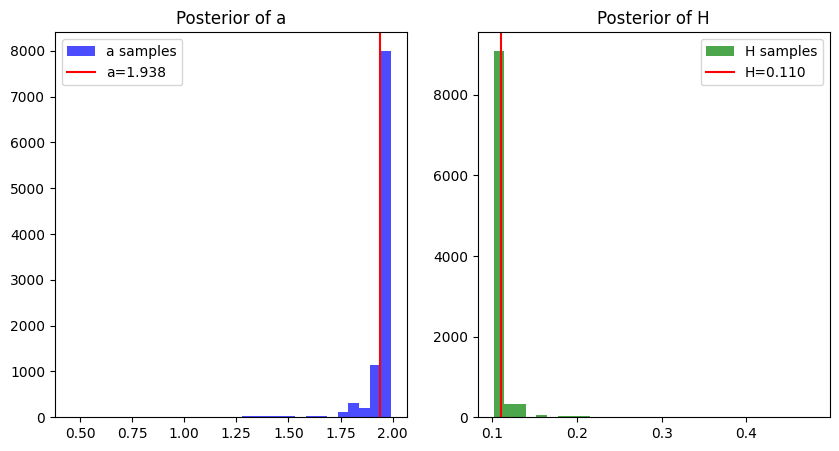

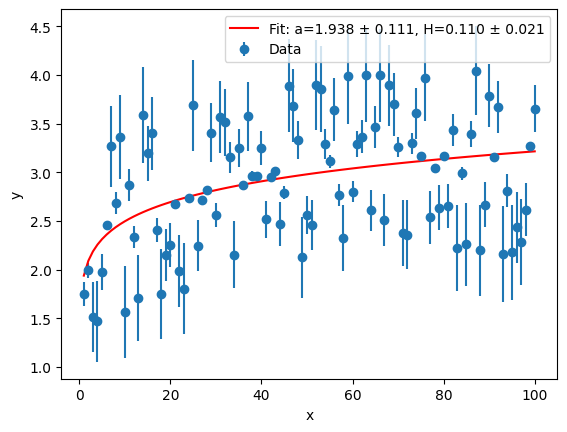

In [114]:
# HMC Implementation
def hmc(x, y, errors, N_mcmc=10000, N_hmc=10, step_sizes=(0.1, 0.1), epsilon=0.0001):
    a_current, H_current = np.random.rand(), np.random.rand()
    step_a, step_H = step_sizes

    # Store samples
    samples = []

    # Log-likelihood function
    def log_likelihood(a, H, sigmas=1):
        model = y_theory(x, a, H)
        return -0.5 * np.sum(((y - model) / sigmas)**2)

    # Initial log-likelihood value
    log_likelihood_current = log_likelihood(a_current, H_current, sigmas=errors)

    for _ in range(N_mcmc):
        ksi0a = np.random.normal()
        ksi0H = np.random.normal()

        for _ in range(N_hmc):
            # Compute gradients
            dHda = -np.sum((y - y_theory(x, a_current, H_current)) * x**H_current / errors**2)
            dHdH = -np.sum((y - y_theory(x, a_current, H_current)) * a_current * np.log(x) * x**H_current / errors**2)

            # Update parameters
            a_new = a_current + ksi0a * epsilon + 0.5 * epsilon**2 * (-dHda)
            H_new = H_current + ksi0H * epsilon + 0.5 * epsilon**2 * (-dHdH)

            # Compute new gradients
            dHda_new = -np.sum((y - y_theory(x, a_new, H_new)) * x**H_new / errors**2)
            dHdH_new = -np.sum((y - y_theory(x, a_new, H_new)) * a_new * np.log(x) * x**H_new / errors**2)

            # Update momentum
            ksi0a += 0.5 * epsilon * (-dHda_new - dHda)
            ksi0H += 0.5 * epsilon * (-dHdH_new - dHdH)

            # Update positions for the next step
            a_current = a_new
            H_current = H_new

        # Propose random step
        a_proposed = a_current + np.random.uniform(-step_a, step_a)
        H_proposed = H_current + np.random.uniform(-step_H, step_H)

        # Compute new log-likelihood
        log_likelihood_proposed = log_likelihood(a_proposed, H_proposed, sigmas=errors)

        # Metropolis acceptance criterion using log-likelihoods
        delta_log_likelihood = log_likelihood_proposed - log_likelihood_current
        if delta_log_likelihood > np.log(np.random.uniform(0, 1)):
            a_current = a_proposed
            H_current = H_proposed
            log_likelihood_current = log_likelihood_proposed

        # Store samples
        samples.append((a_current, H_current))

    return np.array(samples)

# Perform HMC
samples_hmc = hmc(x, y, errors)

# Extract results
a_samples, H_samples = samples_hmc[:, 0], samples_hmc[:, 1]
a_hmc = np.mean(a_samples)
H_hmc = np.mean(H_samples)
a_error_hmc = np.std(a_samples)
H_error_hmc = np.std(H_samples)

# Print results
print(f"Estimated a: {a_hmc:.3f} ± {a_error_hmc:.3f}")
print(f"Estimated H: {H_hmc:.3f} ± {H_error_hmc:.3f}")

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(a_samples, bins=30, color='blue', alpha=0.7, label='a samples')
plt.axvline(a_hmc, color='red', label=f'a={a_hmc:.3f}')
plt.title("Posterior of a")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(H_samples, bins=30, color='green', alpha=0.7, label='H samples')
plt.axvline(H_hmc, color='red', label=f'H={H_hmc:.3f}')
plt.title("Posterior of H")
plt.legend()

plt.show()

# Plot the fit
plt.errorbar(x, y, yerr=errors, fmt='o', label='Data')
plt.plot(x, y_theory(x, a_hmc, H_hmc), label=f'Fit: a={a_hmc:.3f} ± {a_error_hmc:.3f}, H={H_hmc:.3f} ± {H_error_hmc:.3f}', color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


# Q3

Best parameters: a = 2.2091, H = 0.0713


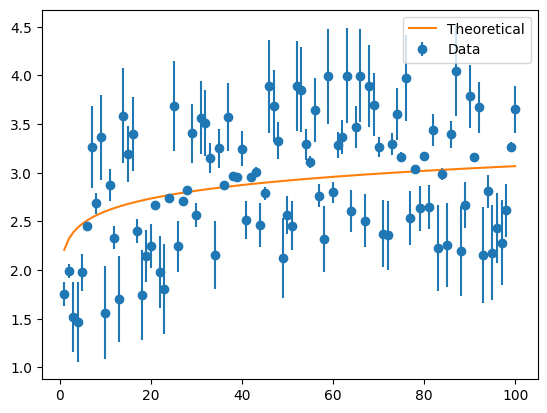

In [115]:
import random
import bisect


# Define the model
def model(a, H, x):
    return a * np.power(x, H)

# Define Chi-Square fitness function
def chi2(yobs, yth, sigma=1):
    return np.sum((yobs - yth) ** 2 / sigma)

# Genetic Algorithm parameters
amin, amax = 1.5, 2.4  # Restrict search space for 'a'
hmin, hmax = 0.001, 1   # Restrict search space for 'H'
da, dh = 0.001, 0.001
n = int(np.log2(int((amax - amin) / da))) + 1  # Bit length
M = 4000  # Population size
p_c = 1   # Crossover probability
p_m = 0.1  # Mutation probability
conv_threshold = 0.001

# Initialize population
pop = []
for _ in range(M):
    a_bin = format(random.randint(0, 2**n - 1), f'0{n}b')
    h_bin = format(random.randint(0, 2**n - 1), f'0{n}b')
    pop.append([a_bin, h_bin])

# Compute fitness for initial population
CHI2 = []
for a_bin, h_bin in pop:
    a = amin + int(a_bin, 2) * (amax - amin) / (2**n - 1)
    h = hmin + int(h_bin, 2) * (hmax - hmin) / (2**n - 1)
    CHI2.append(chi2(y, model(a, h, x), errors))

CHI2 = np.array(CHI2)
L = np.exp(-CHI2 / (2 * CHI2.max()))
R = L / L.sum()

conv = 1  # Initialize convergence condition

while conv > conv_threshold:
    # Proportional selection
    pop_new = []
    for _ in range(M):
        index = bisect.bisect_right(np.cumsum(R), np.random.random())
        pop_new.append(pop[index])

    # Crossover
    for i in range(0, M, 2):
        if random.random() < p_c:
            crossover_point = random.randint(1, n - 1)
            a1, h1 = pop_new[i]
            a2, h2 = pop_new[i + 1]
            a1, a2 = a1[:crossover_point] + a2[crossover_point:], a2[:crossover_point] + a1[crossover_point:]
            h1, h2 = h1[:crossover_point] + h2[crossover_point:], h2[:crossover_point] + h1[crossover_point:]
            pop_new[i], pop_new[i + 1] = [a1, h1], [a2, h2]

    # Mutation (Bit-Flip)
    for j in range(M):
        if random.random() < p_m:
            f = random.randint(0, n - 1)
            a_mut = list(pop_new[j][0])
            h_mut = list(pop_new[j][1])
            a_mut[f] = '0' if a_mut[f] == '1' else '1'
            h_mut[f] = '0' if h_mut[f] == '1' else '1'
            pop_new[j] = [''.join(a_mut), ''.join(h_mut)]

    # Decode binary population
    decoded_pop = []
    for a_bin, h_bin in pop_new:
        a = amin + int(a_bin, 2) * (amax - amin) / (2**n - 1)
        h = hmin + int(h_bin, 2) * (hmax - hmin) / (2**n - 1)
        decoded_pop.append([a, h])

    # Compute new fitness
    CHI2_new = np.array([chi2(y, model(a, h, x), errors) for a, h in decoded_pop])
    L_new = np.exp(-CHI2_new / (2 * CHI2_new.max()))
    R_new = L_new / L_new.sum()

    # Check convergence
    conv = abs(L_new.sum() - L.sum())

    # Update population
    pop = pop_new
    R = R_new
    L = L_new
    p_c -= 0.05  # Decrease crossover probability
    p_m -= 0.01  # Decrease mutation probability

# Extract best parameters
best_idx = np.argmax(L)
a_ga, H_ga = decoded_pop[best_idx]

# Print results
print(f"Best parameters: a = {a_ga:.4f}, H = {H_ga:.4f}")

# Plot results
plt.errorbar(x, y, yerr=errors, fmt='o', label='Data')
plt.plot(x, model(a_ga, H_ga, x), label="Theoretical")
plt.legend()
plt.show()

# Comparing all the resuls:

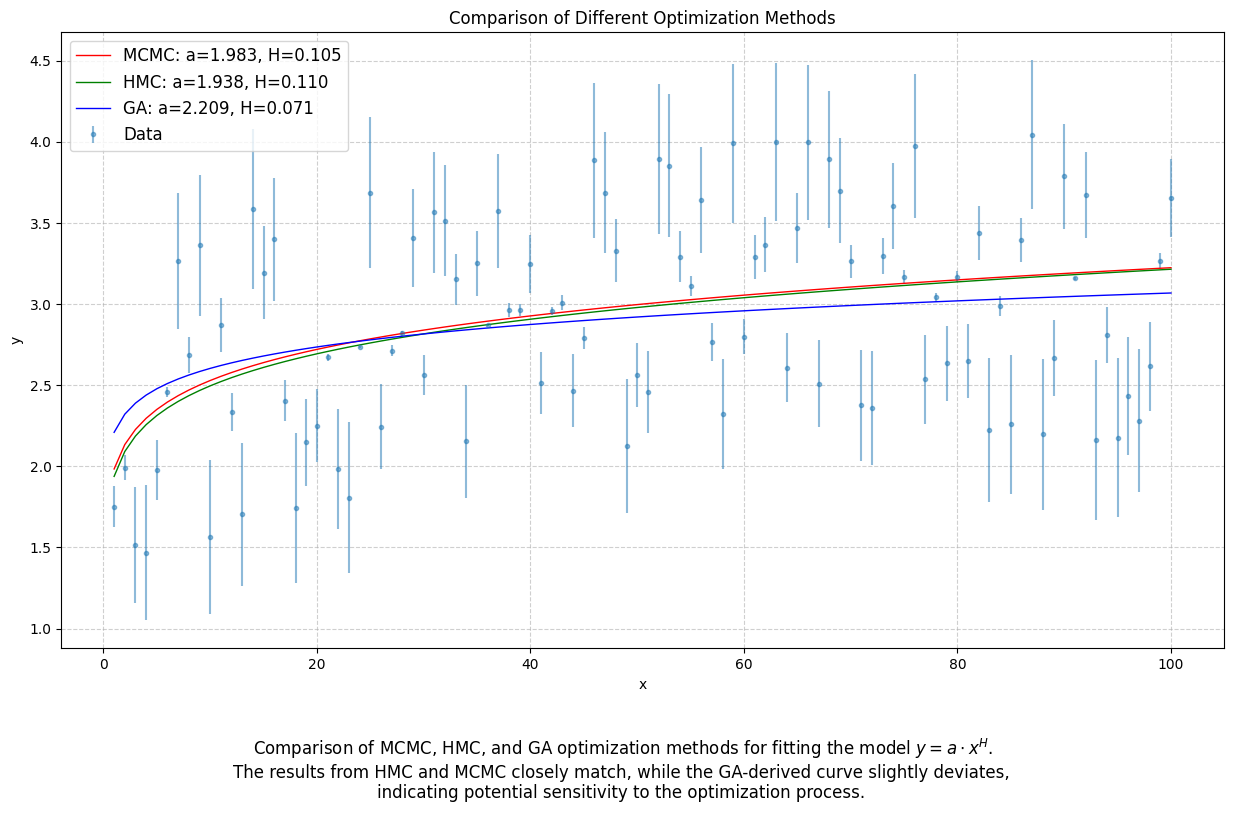

In [116]:
plt.figure(figsize=(15, 8)) 
plt.errorbar(x, y, yerr=errors, alpha=0.5, fmt='.', label='Data')
plt.plot(x, model(a_mcmc, H_mcmc, x), linewidth=1, label=f'MCMC: a={a_mcmc:.3f}, H={H_mcmc:.3f}', color='r')
plt.plot(x, model(a_hmc, H_hmc, x), linewidth=1, label=f'HMC: a={a_hmc:.3f}, H={H_hmc:.3f}', color='g')
plt.plot(x, model(a_ga, H_ga, x), linewidth=1, label=f'GA: a={a_ga:.3f}, H={H_ga:.3f}', color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Comparison of Different Optimization Methods")
caption_text = r"""
Comparison of MCMC, HMC, and GA optimization methods for fitting the model $y = a \cdot x^H$. 
The results from HMC and MCMC closely match, while the GA-derived curve slightly deviates, 
indicating potential sensitivity to the optimization process. 
"""


plt.figtext(0.5, -0.1, caption_text, wrap=True, horizontalalignment='center', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()